In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt

In [2]:
field_types = {
    'StateHoliday': np.dtype(str),
    'PromoInterval': np.dtype(str)
}

train_df = pd.read_csv("train.csv", dtype = field_types, parse_dates = [2])
test_df = pd.read_csv("test.csv", dtype = field_types, parse_dates = [3])
store_df = pd.read_csv("store.csv", dtype = field_types)

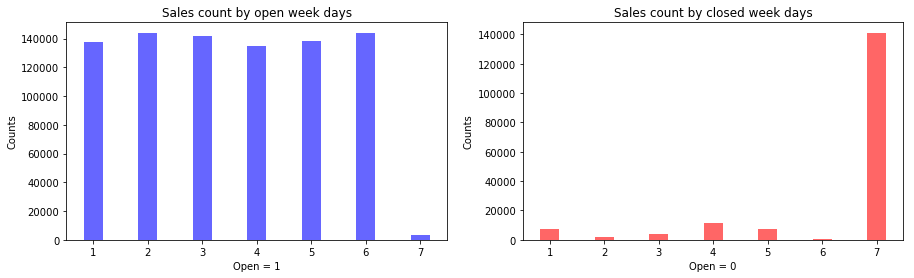

In [3]:
# now check and deal with null values for test_df.Open

count_open = train_df.loc[train_df['Open'] == 1].groupby('DayOfWeek')['Sales'].count()
count_close = train_df.loc[train_df['Open'] == 0].groupby('DayOfWeek')['Sales'].count()
index = count_open.index.values
bar_width = 0.35
opacity = 0.6

plt.subplot(1, 2, 1)
plt.bar(index, count_open, bar_width,
                 alpha=opacity, color='b')
plt.xlabel('Open = 1')
plt.ylabel('Counts')
plt.title('Sales count by open week days')
plt.xticks(index, index)

plt.subplot(1, 2, 2)
plt.bar(index, count_close, bar_width,
                 alpha=opacity, color='r')
plt.xlabel('Open = 0')
plt.ylabel('Counts')
plt.title('Sales count by closed week days')
plt.xticks(index, index)
fig = plt.gcf()
fig.set_size_inches(15, 4)
plt.show()

Looks like normally store closed on Sunday. That should be the rule to fill Null values for test_df['Open']. 

However...

In [4]:
print("Weekdays in test data when Open is null: ", test_df.loc[test_df['Open'].isnull()]['DayOfWeek'].unique())
print("Number of open/closed data in test set: ", test_df.groupby('Open')['Store'].count())

Weekdays in test data when Open is null:  [4 3 2 1 6 5]
Number of open/closed data in test set:  Open
0.0     5984
1.0    35093
Name: Store, dtype: int64


There is no Sunday when Open is null in test data. So it's safe we just set the Open = 1 for those cases for this specific challenge. In general we should by default set Open = 0 for Sunday.

In [5]:
test_df['Open'].fillna(1, inplace = True)
print("Are all test['Open'] non-null? ", test_df['Open'].notnull().all())
print("Number of open/closed data in test set after fillna: ", test_df.groupby('Open')['Store'].count()) 

Are all test['Open'] non-null?  True
Number of open/closed data in test set after fillna:  Open
0.0     5984
1.0    35104
Name: Store, dtype: int64


In [6]:
# check sales for closed stores
train_df.loc[train_df['Open'] == 0]['Sales'].unique()

array([0], dtype=int64)

Closed store has zero sales. We don't need to predict them by model. So just remember all closed stores in test set and predict them all zero after model prediction.

In [7]:
closed_test_ids = test_df.loc[test_df['Open'] == 0]['Id']
train_df = train_df[train_df['Open'] != 0]
test_df = test_df[test_df['Open'] != 0]
print("Closed data in test set: ", closed_test_ids.count())

Closed data in test set:  5984


In [8]:
print("Zero sales when store is open in training set: ", train_df.loc[(train_df['Open'] == 1) & (train_df['Sales'] == 0)]['Sales'].count())

Zero sales when store is open in training set:  54


So there are 54 cases of zero Sales even if Store is open. Don't know why, maybe some missing information...we will exclude them from training set. 

In [9]:
train_df = train_df[train_df['Sales'] > 0]

In [10]:
# check the time span in train and test
print("Training data start from {} to {}".format(train_df['Date'].min().strftime('%Y-%m-%d'), train_df['Date'].max().strftime('%Y-%m-%d')))
print("Test data start from {} to {}".format(test_df['Date'].min().strftime('%Y-%m-%d'), test_df['Date'].max().strftime('%Y-%m-%d')))

Training data start from 2013-01-01 to 2015-07-31
Test data start from 2015-08-01 to 2015-09-17


So we use 4 years data to traing and to predict 2 months data.

Next we will merge train/test with store data and start handling null values in store data.

In [11]:
train_df['SpendPerCustomer'] = train_df.Sales/train_df.Customers
spend_per_customer = train_df.groupby('Store')['SpendPerCustomer'].mean()
average_customers = train_df.groupby('Store')['Customers'].mean()

spend_per_customer.index = np.arange(len(spend_per_customer))
average_customers.index = np.arange(len(average_customers))
store_df['GeneralSpendPerCustomer'] = spend_per_customer
store_df['GeneralAverageCustomers'] = average_customers

train_df = pd.merge(train_df, store_df, on = 'Store')
test_df = pd.merge(test_df, store_df, on = 'Store')

Translate date into Year, Month, Day, WeekDay, WeeOfYear, then remove date column

TODO: since the test data only has 2 months data, we may consider remove Year or even Month feature later.

In [12]:
train_df['Year'] = train_df.Date.dt.year
train_df['Month'] = train_df.Date.dt.month
train_df['Day'] = train_df.Date.dt.day
train_df['DayOfWeek'] = train_df.Date.dt.dayofweek
train_df['WeekOfYear'] = train_df.Date.dt.weekofyear

train_df.drop(['Date'], axis = 1, inplace = True)

test_df['Year'] = test_df.Date.dt.year
test_df['Month'] = test_df.Date.dt.month
test_df['Day'] = test_df.Date.dt.day
test_df['DayOfWeek'] = test_df.Date.dt.dayofweek
test_df['WeekOfYear'] = test_df.Date.dt.weekofyear

test_df.drop(['Date'], axis = 1, inplace = True)

Now handle null values:

In [13]:
for column in train_df.columns:
    if not train_df[column].notnull().all():
        print("Train['{}'] still has null value.".format(column))

Train['CompetitionDistance'] still has null value.
Train['CompetitionOpenSinceMonth'] still has null value.
Train['CompetitionOpenSinceYear'] still has null value.
Train['Promo2SinceWeek'] still has null value.
Train['Promo2SinceYear'] still has null value.
Train['PromoInterval'] still has null value.


Plan for these:
* null values in CompetitionDistance will be set to a big number >> max(competitionOpen), which means no competition nearby
* CompetitionOpenSinceYear/Month will be translatted into number of months, null values will be set to zero which means no competition
* Promo2SinceYear/Week will be translated into number of months. null values will be set to zero which means no Promo2
* PromoInterval is confusing. From the description it just say this is "month to start Promo2 anew", but how long for each round of Promo2 last is not provided. It can be translated into a boolean flag say if current date is in Promo2 or not. We will do a feature correlation analysis later to decide if we want to use it or not.

Next code cell will do as described.

In [14]:
train_df['CompetitionDistance'].fillna(store_df['CompetitionDistance'].max() * 2, inplace = True)
train_df['CompetitionOpenSinceYear'].fillna(0, inplace=True)
train_df['CompetitionOpenSinceMonth'].fillna(0, inplace=True)

train_df['MonthsOfCompetition'] = (train_df['Year'] - train_df['CompetitionOpenSinceYear']) * 12 + \
                train_df['Month'] - train_df['CompetitionOpenSinceMonth']

train_df.loc[train_df.CompetitionOpenSinceYear == 0, 'MonthsOfCompetition'] = 0   
train_df.drop(['CompetitionOpenSinceYear'], axis = 1, inplace = True)
train_df.drop(['CompetitionOpenSinceMonth'], axis = 1, inplace = True)

test_df['CompetitionDistance'].fillna(store_df['CompetitionDistance'].max() * 2, inplace=True)
test_df['CompetitionOpenSinceYear'].fillna(0, inplace=True)
test_df['CompetitionOpenSinceMonth'].fillna(0, inplace=True)

test_df['MonthsOfCompetition'] = (test_df['Year'] - test_df['CompetitionOpenSinceYear']) * 12 + \
                test_df['Month'] - test_df['CompetitionOpenSinceMonth']

test_df.loc[test_df.CompetitionOpenSinceYear == 0, 'MonthsOfCompetition'] = 0   
test_df.drop(['CompetitionOpenSinceYear'], axis = 1, inplace = True)
test_df.drop(['CompetitionOpenSinceMonth'], axis = 1, inplace = True)

train_df['Promo2SinceYear'].fillna(0, inplace=True)
train_df['Promo2SinceWeek'].fillna(0, inplace=True)

train_df['MonthsOfPromo2'] = (train_df['Year'] - train_df['Promo2SinceYear']) * 12 + \
        (train_df['WeekOfYear'] - train_df['Promo2SinceWeek'])/4

train_df.loc[train_df.Promo2SinceWeek==0, 'MonthsOfPromo2'] = 0
train_df.drop(['Promo2SinceYear'], axis = 1, inplace = True)
train_df.drop(['Promo2SinceWeek'], axis = 1, inplace = True)

test_df['Promo2SinceYear'].fillna(0, inplace=True)
test_df['Promo2SinceWeek'].fillna(0, inplace=True)

test_df['MonthsOfPromo2'] = (test_df['Year'] - test_df['Promo2SinceYear']) * 12 + \
        (test_df['WeekOfYear'] - test_df['Promo2SinceWeek'])/4

test_df.loc[test_df.Promo2SinceWeek==0, 'MonthsOfPromo2'] = 0
test_df.drop(['Promo2SinceYear'], axis = 1, inplace = True)
test_df.drop(['Promo2SinceWeek'], axis = 1, inplace = True)

In [15]:
train_df['PromoInterval'].fillna('', inplace=True)

month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
         7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
train_df['monthStr'] = train_df.Month.map(month2str)
train_df['IsPromo2Month'] = 0
for interval in train_df.PromoInterval.unique():
    if interval != '':
        for month in interval.split(','):
            train_df.loc[(train_df.monthStr == month) & (train_df.PromoInterval == interval), 'IsPromo2Month'] = 1
            

test_df['PromoInterval'].fillna('', inplace=True)

month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
         7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
test_df['monthStr'] = test_df.Month.map(month2str)
test_df['IsPromo2Month'] = 0
for interval in test_df.PromoInterval.unique():
    if interval != '':
        for month in interval.split(','):
            test_df.loc[(test_df.monthStr == month) & (test_df.PromoInterval == interval), 'IsPromo2Month'] = 1

train_df.drop(['monthStr'], axis = 1, inplace = True)
train_df.drop(['PromoInterval'], axis = 1, inplace = True)
test_df.drop(['monthStr'], axis = 1, inplace = True)
test_df.drop(['PromoInterval'], axis = 1, inplace = True)

Now change categorical data into numbers: 

In [16]:
map = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
train_df['StateHoliday'].replace(map, inplace = True)
train_df['StoreType'].replace(map, inplace = True)
train_df['Assortment'].replace(map, inplace = True)

test_df['StateHoliday'].replace(map, inplace = True)
test_df['StoreType'].replace(map, inplace = True)
test_df['Assortment'].replace(map, inplace = True)

Let's do one-hot encoding for categorical data.

In [17]:
store_sales = train_df.groupby(['Store', 'DayOfWeek', 'Promo', 'StateHoliday'])['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SpendPerCustomer'].mean()
store_sales = pd.DataFrame(store_sales.values, columns = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SalesPerCustomer'])

In [18]:
store_customers = train_df.groupby(['Store', 'DayOfWeek', 'Promo', 'StateHoliday'])['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'Customers'].mean()
store_customers = pd.DataFrame(store_customers.values, columns = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'AverageCustomer'])

In [19]:
train_df = pd.merge(train_df, store_sales, on = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday'], how='left')
train_df = pd.merge(train_df, store_customers, on = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday'], how='left')
test_df = pd.merge(test_df, store_sales, on = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday'], how='left')
test_df = pd.merge(test_df, store_customers, on = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday'], how='left')

In [20]:
null_spc = test_df.SalesPerCustomer.notnull()
null_spc[null_spc == False].index
#test_df.iloc[1780, :]
test_df.iloc[null_spc[null_spc == False].index, [-2]] = test_df.iloc[null_spc[null_spc == False].index, :].GeneralSpendPerCustomer
test_df.iloc[null_spc[null_spc == False].index, [-1]] = test_df.iloc[null_spc[null_spc == False].index, :].GeneralAverageCustomers

In [21]:
train_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SpendPerCustomer,StoreType,...,GeneralAverageCustomers,Year,Month,Day,WeekOfYear,MonthsOfCompetition,MonthsOfPromo2,IsPromoMonth,SalesPerCustomer,AverageCustomer
0,1,4,5263,555,1,1,0,1,9.482883,3,...,564.049936,2015,7,31,31,82.0,0.0,0,8.730890,588.194030
1,1,3,5020,546,1,1,0,1,9.194139,3,...,564.049936,2015,7,30,31,82.0,0.0,0,8.668448,571.735294
2,1,2,4782,523,1,1,0,1,9.143403,3,...,564.049936,2015,7,29,31,82.0,0.0,0,8.822692,582.112676
3,1,1,5011,560,1,1,0,1,8.948214,3,...,564.049936,2015,7,28,31,82.0,0.0,0,9.045536,593.069444
4,1,0,6102,612,1,1,0,1,9.970588,3,...,564.049936,2015,7,27,31,82.0,0.0,0,9.239066,633.194444


In [22]:
train_df['LastQuarterStartMonth'] = train_df.Month.apply(lambda month: month - 3 if month > 3 else 9 + month)
#test_df['LastQuarterStartMonth'] = test_df.Month.apply(lambda month: month - 3 if month > 3 else 9 + month)

In [23]:
def last_quater_year(row):
    if row['Month'] > 3:
        return row['Year']
    else:
        return row['Year'] - 1

train_df['LastQuarterStartYear'] = train_df.apply(last_quater_year, 1)
#test_df['LastQuarterStartYear'] = test_df.apply(last_quater_year, 1)

In [24]:
sales_last_quater = train_df.groupby(['Store', 'Year', 'Month', 'LastQuarterStartYear', 'LastQuarterStartMonth'], as_index=False)['Sales'].mean()

In [26]:
sales_last_quater = sales_last_quater.rename(columns = {'Sales': 'SalesLastQuarter', 
                                                        'Year': 'LastQuarterEndYear', 
                                                        'Month': 'LastQuarterEndMonth'})

In [27]:
train_df['LastQuarterEndYear'] = train_df['Year']
train_df['LastQuarterEndMonth'] = train_df['Month']

test_df['LastQuarterStartYear'] = 2015
test_df['LastQuarterStartMonth'] = 4
test_df['LastQuarterEndYear'] = 2015
test_df['LastQuarterEndMonth'] = 7
#train_df[(train_df.Year == 2013) & (train_df.Month == 1)]

In [28]:
train_df = pd.merge(train_df, sales_last_quater, on = ['Store', 'LastQuarterStartYear', 'LastQuarterStartMonth', 
                                                       'LastQuarterEndYear', 'LastQuarterEndMonth'], how='left')

In [29]:
#train_df[(train_df['Year'] == 2013) & (train_df['Month'] <= 3)].loc[:, ['Year', 'Month', 'LastQuarterMonth', 
#                                                                        'LastQuarterYear', 'SalesLastQuarter']].head()

test_df = pd.merge(test_df, sales_last_quater, on = ['Store', 'LastQuarterStartYear', 'LastQuarterStartMonth', 
                                                     'LastQuarterEndYear', 'LastQuarterEndMonth'], how='left')
#test_df.head()

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,...,MonthsOfCompetition,MonthsOfPromo2,IsPromoMonth,SalesPerCustomer,AverageCustomer,LastQuarterStartYear,LastQuarterStartMonth,LastQuarterEndYear,LastQuarterEndMonth,SalesLastQuarter
0,1,1,3,1.0,1,0,0,3,1,1270.0,...,84.0,0.0,0,8.668448,571.735294,2015,4,2015,7,4491.333333
1,857,1,2,1.0,1,0,0,3,1,1270.0,...,84.0,0.0,0,8.822692,582.112676,2015,4,2015,7,4491.333333
2,1713,1,1,1.0,1,0,0,3,1,1270.0,...,84.0,0.0,0,9.045536,593.069444,2015,4,2015,7,4491.333333
3,2569,1,0,1.0,1,0,0,3,1,1270.0,...,84.0,0.0,0,9.239066,633.194444,2015,4,2015,7,4491.333333
4,4281,1,5,1.0,0,0,0,3,1,1270.0,...,84.0,0.0,0,8.264309,597.552239,2015,4,2015,7,4491.333333


In [30]:
train_df.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'SpendPerCustomer', 'StoreType',
       'Assortment', 'CompetitionDistance', 'Promo2',
       'GeneralSpendPerCustomer', 'GeneralAverageCustomers', 'Year', 'Month',
       'Day', 'WeekOfYear', 'MonthsOfCompetition', 'MonthsOfPromo2',
       'IsPromoMonth', 'SalesPerCustomer', 'AverageCustomer',
       'LastQuarterStartMonth', 'LastQuarterStartYear', 'LastQuarterEndYear',
       'LastQuarterEndMonth', 'SalesLastQuarter'],
      dtype='object')

In [31]:
train_df_copy = train_df.copy()
test_df_copy = test_df.copy()

In [33]:
y = np.log(train_df['Sales'].values + 1)

train_df.drop(['Sales'], axis = 1, inplace = True)
train_df.drop(['SpendPerCustomer'], axis = 1, inplace = True)
train_df.drop(['GeneralSpendPerCustomer'], axis = 1, inplace = True)
train_df.drop(['GeneralAverageCustomers'], axis = 1, inplace = True)
train_df.drop(['LastQuarterStartMonth'], axis = 1, inplace = True)
train_df.drop(['LastQuarterStartYear'], axis = 1, inplace = True)
train_df.drop(['LastQuarterEndMonth'], axis = 1, inplace = True)
train_df.drop(['LastQuarterEndYear'], axis = 1, inplace = True)
train_df.drop(['Customers'], axis = 1, inplace = True)
train_df.drop(['Store'], axis = 1, inplace = True)

test_df.drop(['Store'], axis = 1, inplace = True)
test_df.drop(['GeneralSpendPerCustomer'], axis = 1, inplace = True)
test_df.drop(['GeneralAverageCustomers'], axis = 1, inplace = True)
test_df.drop(['LastQuarterStartMonth'], axis = 1, inplace = True)
test_df.drop(['LastQuarterStartYear'], axis = 1, inplace = True)
test_df.drop(['LastQuarterEndMonth'], axis = 1, inplace = True)
test_df.drop(['LastQuarterEndYear'], axis = 1, inplace = True)

# Let's remove Year first
train_df.drop(['Year'], axis = 1, inplace = True)
test_df.drop(['Year'], axis = 1, inplace = True)

X = train_df.values

In [34]:
train_df.columns

Index(['DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance', 'Promo2', 'Month',
       'Day', 'WeekOfYear', 'MonthsOfCompetition', 'MonthsOfPromo2',
       'IsPromoMonth', 'SalesPerCustomer', 'AverageCustomer',
       'SalesLastQuarter'],
      dtype='object')

In [35]:
from sklearn.preprocessing import OneHotEncoder

onehotencoder = OneHotEncoder(categorical_features = [3, 5, 6])
X = onehotencoder.fit_transform(X).toarray()
print("X.shape: ", X.shape)
X = X[:, 1:]

X.shape:  (844338, 26)


In [36]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.012, random_state = 888)
#X_valid_1, X_valid_2, y_valid_1, y_valid_2 = train_test_split(X_valid, y_valid, test_size = 0.5, random_state = 1024)

In [37]:
def rmspe(yhat, dtrain):
    y = np.exp(dtrain.get_label()) - 1
    yhat = np.exp(yhat) - 1
    return "rmspe", np.sqrt(np.mean((yhat/y-1)) ** 2)

In [38]:
import xgboost as xgb

params = {
    'objective': "reg:linear",
    'booster': 'gbtree',
    'n_estimators': 20,
    'max_depth': 10,
    'subsample': 0.9,
    'colsample_bytree': 0.7,
    'slient' : 1.0,
    'n_jobs' : 16,
    #'min_child_weight' : 0.1,
    #'reg_lambda' : 3,
    #'gamma' : 1,
    'eta' : 0.3,
    'seed': 0
    #'eval_metric' : 'rmspe'
}

num_rounds = 2000
dtrain = xgb.DMatrix(X_train, label = y_train)
dvalid = xgb.DMatrix(X_valid, label = y_valid)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
evals_result = {}

from datetime import datetime

start_time = datetime.now()
    
predictor = xgb.train(params, dtrain, num_rounds, watchlist, verbose_eval = 25, 
                      evals_result = evals_result, 
                      feval = rmspe, 
                      early_stopping_rounds=100)

end_time = datetime.now()
diff = end_time - start_time
print("time spent: ", diff.total_seconds())    

[0]	train-rmse:5.78961	valid-rmse:5.79131	train-rmspe:0.996916	valid-rmspe:0.996925
Multiple eval metrics have been passed: 'valid-rmspe' will be used for early stopping.

Will train until valid-rmspe hasn't improved in 100 rounds.
[25]	train-rmse:0.098481	valid-rmse:0.099115	train-rmspe:0.004473	valid-rmspe:0.001467
[50]	train-rmse:0.090241	valid-rmse:0.093184	train-rmspe:0.004418	valid-rmspe:0.001844
[75]	train-rmse:0.086384	valid-rmse:0.09129	train-rmspe:0.003965	valid-rmspe:0.001824
[100]	train-rmse:0.082592	valid-rmse:0.089829	train-rmspe:0.003585	valid-rmspe:0.00168
Stopping. Best iteration:
[22]	train-rmse:0.101183	valid-rmse:0.101493	train-rmspe:0.003238	valid-rmspe:0.000124

time spent:  184.004778


In [39]:
valid_pred = predictor.predict(xgb.DMatrix(X_valid))
yhat = np.exp(valid_pred) - 1
y = np.exp(y_valid) - 1
valid_score = np.sqrt(np.mean((1 - yhat/y)) ** 2)
#valid_score = np.sqrt(np.mean((1 - valid_pred/y_valid)) ** 2)
print("Validation set rmspe score: {:.5f}".format(valid_score))

Validation set rmspe score: 0.00163


In [40]:
test_ids = test_df['Id'].values
test_df.drop(['Id'], axis = 1, inplace = True)

In [41]:
for column in test_df.columns:
    if not test_df[column].notnull().all():
        print("Test['{}'] still has null value.".format(column))

In [42]:
test_set = test_df.values
test_set = onehotencoder.transform(test_set).toarray()
test_set = test_set[:, 1:]

dtest = xgb.DMatrix(test_set)
test_pred = predictor.predict(dtest)
test_pred = np.exp(test_pred) - 1

In [43]:
test_df_copy['Sales'] = test_pred
test_df_copy['LastQuarterStartMonth'] = test_df_copy['Month'] - 3
test_df_copy['LastQuarterEndMonth'] = test_df_copy['Month']
train_df_copy = train_df_copy.append(test_df_copy)

In [44]:
test_df_copy.drop(['Sales'], axis = 1, inplace = True)
test_df_copy.drop(['SalesLastQuarter'], axis = 1, inplace = True)

In [45]:
sales_last_quarter = train_df_copy.groupby(['Store', 'LastQuarterStartYear',  'LastQuarterStartMonth',
                                     'LastQuarterEndYear',  'LastQuarterEndMonth',], as_index=False)['Sales'].mean()
sales_last_quarter = sales_last_quarter.rename(columns = {'Sales': 'SalesLastQuarter'})

In [46]:
test_df = pd.merge(test_df_copy, sales_last_quarter, on = ['Store', 'LastQuarterStartYear', 'LastQuarterStartMonth', 
                                                     'LastQuarterEndYear', 'LastQuarterEndMonth'], how='left')

In [47]:
test_df.drop(['Store'], axis = 1, inplace = True)
test_df.drop(['GeneralSpendPerCustomer'], axis = 1, inplace = True)
test_df.drop(['GeneralAverageCustomers'], axis = 1, inplace = True)
test_df.drop(['LastQuarterStartMonth'], axis = 1, inplace = True)
test_df.drop(['LastQuarterStartYear'], axis = 1, inplace = True)
test_df.drop(['LastQuarterEndMonth'], axis = 1, inplace = True)
test_df.drop(['LastQuarterEndYear'], axis = 1, inplace = True)
test_df.drop(['Year'], axis = 1, inplace = True)

test_ids = test_df['Id'].values
test_df.drop(['Id'], axis = 1, inplace = True)

test_set = test_df.values
test_set = onehotencoder.transform(test_set).toarray()
test_set = test_set[:, 1:]

dtest = xgb.DMatrix(test_set)
test_pred = predictor.predict(dtest)
test_pred = np.exp(test_pred) - 1

In [48]:
# add id column, add closed data, sort and write to result file
result_open = pd.DataFrame({'Id': test_ids, 'Sales': test_pred})
result_closed = pd.DataFrame({'Id': closed_test_ids, 'Sales': 0})
result = result_open.append(result_closed).sort_values(['Id'])
result.to_csv('rossmann_result.csv', index = False)

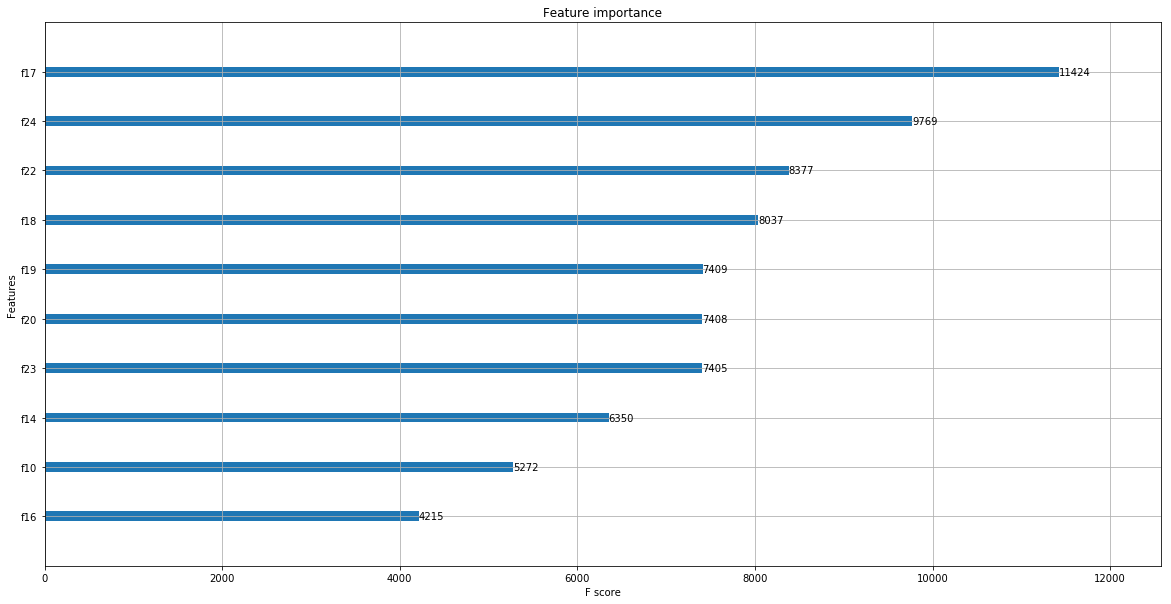

In [49]:
ax = xgb.plot_importance(predictor, max_num_features = 10)
fig = ax.figure
fig.set_size_inches(20, 10)
plt.show()